In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
from scipy import stats
from scipy.stats import linregress
from scipy.stats import ttest_ind
from scipy.stats import shapiro
import warnings; warnings.simplefilter('ignore')

In [61]:
path = r'/Users/bryanleavelle/DATA PROJECTS/DARWINS FINCHES/archive/'

In [62]:
df75 = pd.read_csv(os.path.join(path, 'finch_beaks_1975.csv'))

In [63]:
df12 = df = pd.read_csv(os.path.join(path, 'finch_beaks_2012.csv'))

# TABLE OF CONTENTS

1 - INTRODUCTION <BR>
2 - LETS GO (CLEAN AND WRANGLE) <BR>
3 - INITIAL EXPLORATION <BR>
4 - SCATTER PLOT CITY <BR>
5 - DISTRO PLOTS AND T-TESTS <BR>
6 - CONCLUSION

# 1. INTRODUCTION:
## I LOVE EVOLUTION.
Before I got into data analysis, I was a philosophy and biology major. Im also a bird photographer, so I read about birds and evolution all the time, and talk about it constanty with my friends. When I found this Finch dataset on Kaggle, I was so psyched. I had heard of this couple in ornithology courses, and know all about Darwin and his beloved finches. SO, I had to play with this data set... how fun to be able to use raw data to come to the same conclusions that Darwin did way back in the early 19th century? What a hoot! <br> <br>
So, without any further delay... lets check Darwin's work.

# 2. LETS GO - CLEAN/WRANGLE
 OK, now on to the analysis. First, lets wrangle and clean up these files a little to make our work a little easier down the road.

In [64]:
df75.head(5)

,band,species,"Beak length, mm","Beak depth, mm"
0,2,fortis,9.4,8.0
1,9,fortis,9.2,8.3
2,12,fortis,9.5,7.5
3,15,fortis,9.5,8.0
4,305,fortis,11.5,9.9


In [65]:
df12.head()

,band,species,blength,bdepth
0,19022,fortis,10.0,8.5
1,19028,fortis,12.5,8.9
2,19032,fortis,9.3,7.5
3,19041,fortis,10.3,9.6
4,19044,fortis,11.0,9.2


I like the column names in the 2012 dataset a lot more. First lets change the names of the 1975 set to match 2012.

In [68]:
df75 = df75.rename({'Beak length, mm' :  'blength', 'Beak depth, mm' : 'bdepth'}, axis =1)

In [ ]:
# also band information is useless to us so lets delete those columns

del df12['band']
del df75['band']

In [122]:
# annnnd add a year column so we can join the data sets later on.

df75['year'] = 1975
df12['year'] = 2012

In [86]:
df75

,species,blength,bdepth,year
0,fortis,9.40,8.00,1975
1,fortis,9.20,8.30,1975
2,fortis,9.50,7.50,1975
3,fortis,9.50,8.00,1975
4,fortis,11.50,9.90,1975
...,...,...,...,...
398,scandens,14.55,9.45,1975
399,scandens,14.05,9.05,1975
400,scandens,14.45,8.75,1975
401,scandens,15.05,9.45,1975


### O baby.
that is much nicer.

# 3. INITIAL EXPLORATION:

To kick things off lets just look at some mins, means and maxes.

In [89]:
df75.groupby('species').agg(['min', 'max', 'mean'])

blength                  bdepth                   year              
             min    max      mean    min    max      mean   min   max    mean
species                                                                      
fortis       8.7  12.20  10.56519    7.5  10.98  9.171646  1975  1975  1975.0
scandens    12.8  15.94  14.12092    7.9  10.40  8.960000  1975  1975  1975.0

in 1975 scandens run longer, shallower beaks on average than fortis

In [90]:
df12.groupby('species').agg(['min', 'max', 'mean'])

blength                  bdepth                  year              
             min   max       mean    min   max      mean   min   max    mean
species                                                                     
fortis       9.0  12.9  10.517355    7.2  11.1  8.605372  2012  2012  2012.0
scandens    11.4  15.2  13.421024    7.7  11.0  9.186220  2012  2012  2012.0

in 2012, fortis beaks were a little longer and scandens were a little shorter on average. Fortis beaks were shallower than scandens on average in 2012. In other words, it seems things changed.

### im willing to bet that we can prove statistically that these changes are significant.

# 4. SCATTER PLOT CITY:

First things first, lets bring both years of data together into one dataframe:

In [91]:
df_all = pd.concat([df75,df12]).reset_index(drop=True)

In [151]:
# make them charts BIG

sns.set(rc = {'figure.figsize':(13,8)})

<AxesSubplot:xlabel='blength', ylabel='bdepth'>

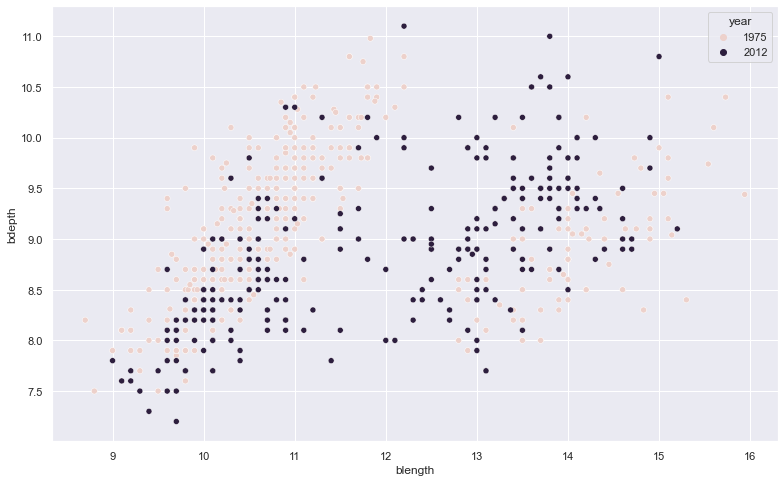

In [126]:
#Scatter of bdepth and blength, combined species

sns.scatterplot(data=df_all, x="blength", y="bdepth", hue='year')

### hmm.
Looks like we have scandens on the right and fortis on the left (see above camparison of means of values). I see a lot more change on the left grouping between years than on the right. 
Lets split the species into different data frames so we can analyze them seperately

In [152]:
#split df

df_scan = df_all[df_all['species'] == 'scandens']
df_fort = df_all[df_all['species'] == 'fortis']

<AxesSubplot:xlabel='blength', ylabel='bdepth'>

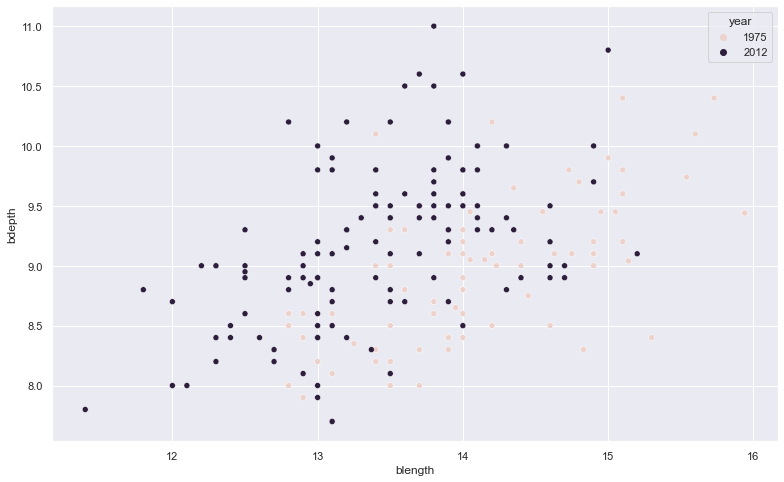

In [128]:
#scandens sccatter

sns.scatterplot(data=df_scan, x="blength", y="bdepth", hue='year')

Ok, so for scandens, at first glance I notice a shift to the left, a reduction in beak length from '75 to '12 and an increase in depth.

<AxesSubplot:xlabel='blength', ylabel='bdepth'>

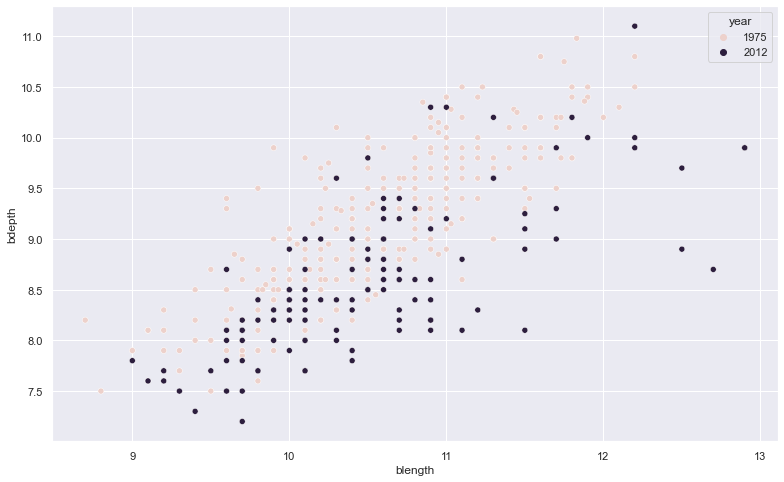

In [129]:
#fortis scatter

sns.scatterplot(data=df_fort, x="blength", y="bdepth", hue='year')

For fortis, I see a shift towards reduced beak depth and a possible  increase in beak length.

# 5. DISTRO PLOTS AND T-TESTS

Im going to perform welch's t-tests to compare means between years in each species for the observations we made in the above scatter plots:<br>
<br>1 - reduction in beak length and increase in beak depth in species scandens
<br> 2 - increase in beak length and decrease in beak depth in species fortis

### starting with scandens:

In [130]:
#create our test groups for scandens

scan75 = df_scan[df_scan['year'] == 1975]
scan12 = df_scan[df_scan['year'] == 2012]

First, we should check to see if we have a normal distrubution in this data.

<AxesSubplot:xlabel='blength', ylabel='Density'>

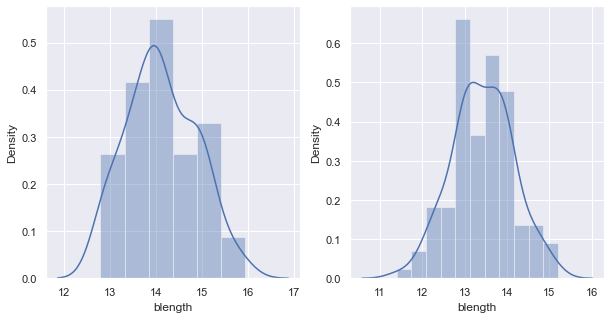

In [150]:
#distribution plots for beak length in scandens for 1975 and 2012

f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))


sns.distplot(scan75['blength'], ax = ax1)
sns.distplot(scan12['blength'], ax = ax2)

Hard to tell if these are true normal distributions. Good opportunity to try a new trick i learned from Towards Data Science to run Shapiro tests:

In [177]:
# Thank you to Towards Data Science for this dope little piece of code


# check 1975 beak length for normal distribution
stat, p = shapiro(scan75['blength'])
print('stat=%.3f, p=%.3f\n' % (stat, p))
if p > 0.05:
    print('Probably Gaussian =D')
else:
    print('Probably not Gaussian =/')

stat=0.976, p=0.105

Probably Gaussian =D


In [178]:
# check 2012 beak length for normal distribution


stat, p = shapiro(scan12['blength'])
print('stat=%.3f, p=%.3f\n' % (stat, p))
if p > 0.05:
    print('Probably Gaussian =D')
else:
    print('Probably not Gaussian =/')

stat=0.993, p=0.784

Probably Gaussian =D


### Looks good! Lets run a T-test 

In [131]:
#run a t-test

ttest_ind(scan75['blength'], scan12['blength'], equal_var = False)

Ttest_indResult(statistic=6.786891770393563, pvalue=1.617177604865025e-10)

Welp, they certainly are different! Extremely low p-value points to an extremeley low probability this difference in beak length is due to random chance. So either god bashed those beaks back in or... evolution!

Ok, how about that beak depth?

<AxesSubplot:xlabel='bdepth', ylabel='Density'>

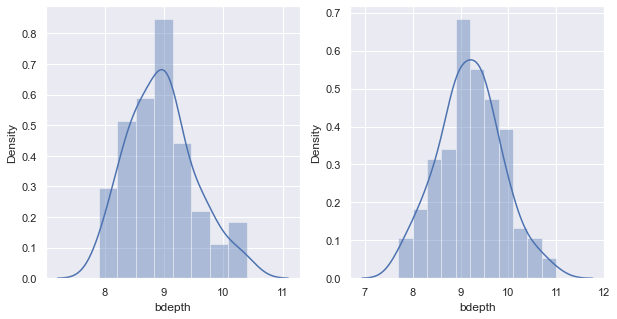

In [165]:
f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))


sns.distplot(scan75['bdepth'], ax = ax1)
sns.distplot(scan12['bdepth'], ax = ax2)

In [179]:

# check 1975 beak depth for normal distribution
stat, p = shapiro(scan75['bdepth'])
print('stat=%.3f, p=%.3f\n' % (stat, p))
if p > 0.05:
    print('Probably Gaussian =D')
else:
    print('Probably not Gaussian =/')

stat=0.975, p=0.093

Probably Gaussian =D


In [180]:

# check 1975 beak depth for normal distribution
stat, p = shapiro(scan12['bdepth'])
print('stat=%.3f, p=%.3f\n' % (stat, p))
if p > 0.05:
    print('Probably Gaussian =D')
else:
    print('Probably not Gaussian =/')

stat=0.992, p=0.639

Probably Gaussian =D


Histo's and shapiro tests say we are probably normally distributed on this variable, too. Lets run another t-test

In [169]:
ttest_ind(scan75['bdepth'], scan12['bdepth'], equal_var = False)

Ttest_indResult(statistic=-2.662956854358034, pvalue=0.008368168999281883)

# hot damn, reject that ho

Beak depth changed in scandens between 1975 and 2012

# Next up, Fortis!



In [132]:
#create test groups

fortis75 = df_fort[df_fort['year']==1975]
fortis12 = df_fort[df_fort['year']==2012]
    

<AxesSubplot:xlabel='blength', ylabel='Density'>

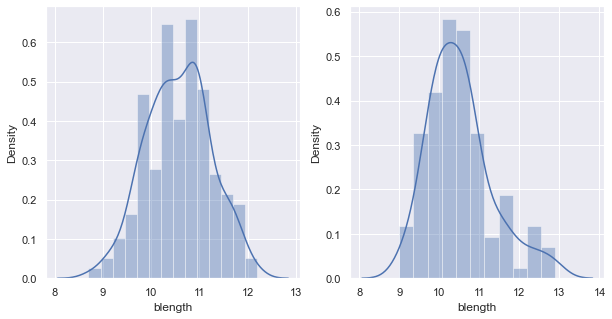

In [154]:
#distribution plots for beak length in fortis for 1975 and 2012

f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))


sns.distplot(fortis75['blength'], ax = ax1)
sns.distplot(fortis12['blength'], ax = ax2)

In [181]:
stat, p = shapiro(fortis12['blength'])
print('stat=%.3f, p=%.3f\n' % (stat, p))
if p > 0.05:
    print('Probably Gaussian =D')
else:
    print('Probably not Gaussian =/')

stat=0.942, p=0.000

Probably not Gaussian =/


### F.
ok what about fortis beak depth?

<AxesSubplot:xlabel='bdepth', ylabel='Density'>

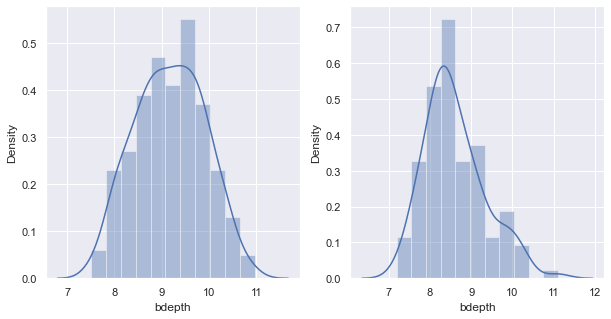

In [156]:
#distribution plots for beak depth in fortis for 1975 and 2012

f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))


sns.distplot(fortis75['bdepth'], ax = ax1)
sns.distplot(fortis12['bdepth'], ax = ax2)

wuh oh (right graph)

In [182]:
stat, p = shapiro(fortis12['bdepth'])
print('stat=%.3f, p=%.3f\n' % (stat, p))
if p > 0.05:
    print('Probably Gaussian =D')
else:
    print('Probably not Gaussian =/')

stat=0.958, p=0.001

Probably not Gaussian =/


## dang! 
This should only really matter if if we have a small sample size, insanely abnormal distributions or crazy outliers. 

In [158]:
fortis12.shape

(121, 4)

In [162]:
fortis75.shape

(316, 4)

OK, so we have a good sample size, and honestly these distributions are not INSANELY abnormal, especially since a normal distribution does not really exist anywhere in nature at all! So, since a small sample is usally "under 30", and we have over a hundred observations in both these samples... Im still going to use t-tests.<br>
### length first

In [133]:
#beak length t test

ttest_ind(fortis75['blength'], fortis12['blength'], equal_var = False)

Ttest_indResult(statistic=0.5791225584108268, pvalue=0.5632030784575568)

#### my look-at-the-graph gut feeling was incorrect. 
cannot reject a null with a t stat and pvalue like THAT. In other words:
### No difference in fortis beak length

In [134]:
#beak depth t-test

ttest_ind(fortis75['bdepth'], fortis12['bdepth'], equal_var = False)

Ttest_indResult(statistic=7.217487552951729, pvalue=8.621932233662599e-12)

nice! 
### Beaks got shallower in fortis!


# 6. CONCLUSION:
### we found evidence of changing beak shapes in both species studied.

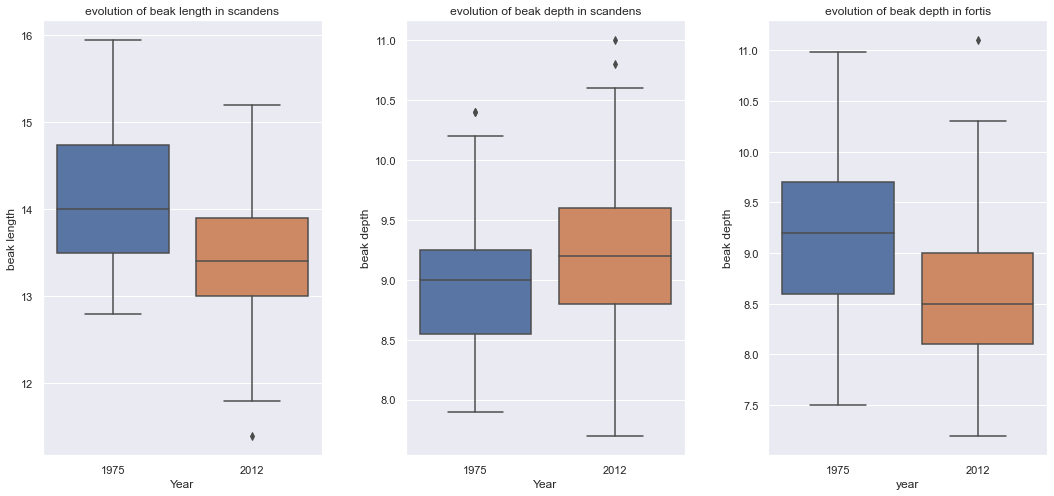

In [176]:
f, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,8))

#build plots
sns.boxplot(x='year',y='blength', data=df_scan, ax=ax1)
sns.boxplot(x='year',y='bdepth', data=df_scan, ax=ax2) 
sns.boxplot(x='year',y='bdepth',data=df_fort, ax=ax3)    
ax1.set(xlabel = 'Year', ylabel = 'beak length')
ax2.set(xlabel = 'Year', ylabel = 'beak depth')   
ax3.set(xlabel = 'year', ylabel = 'beak depth')   
ax1.set_title('evolution of beak length in scandens')   
ax2.set_title('evolution of beak depth in scandens') 
ax3.set_title('evolution of beak depth in fortis')   
plt.subplots_adjust(wspace = 0.3) 

We can see above box plots for both species and their respective changes in beak shapes.

# DARWIN WINS AGAIN

I wonder what he would think of Python...